In [ ]:
!pip install flask-ngrok alpha_vantage pandas numpy scikit-learn tensorflow matplotlib


In [ ]:
import pandas as pd
from alpha_vantage.timeseries import TimeSeries

# Alpha Vantage API Key
api_key = 'EHHIB7PXEQ6A4889'

def get_stock_data(symbol):
    ts = TimeSeries(key=api_key, output_format='pandas')
    data, _ = ts.get_daily(symbol=symbol, outputsize='full')  # Get full historical data
    data = data['4. close']  # We'll focus on the 'Close' price
    return data


In [ ]:
symbol = 'AAPL'
stock_data = get_stock_data(symbol)
print(stock_data.head())


date
2024-10-15    233.85
2024-10-14    231.30
2024-10-11    227.55
2024-10-10    229.04
2024-10-09    229.54
Name: 4. close, dtype: float64


In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def preprocess_data(data):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data.values.reshape(-1, 1))

    # Creating training dataset
    X_train, y_train = [], []
    for i in range(60, len(scaled_data)):
        X_train.append(scaled_data[i-60:i, 0])
        y_train.append(scaled_data[i, 0])

    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))  # Reshape for LSTM
    return X_train, y_train, scaler

X_train, y_train, scaler = preprocess_data(stock_data)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

def build_lstm_model():
    model = Sequential()

    # First LSTM layer
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(0.2))

    # Second LSTM layer
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))

    # Output layer
    model.add(Dense(units=1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Build and train the model
model = build_lstm_model()
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Saving the model in native Keras format
model.save('stock_price_model.keras')
print("Model saved as stock_price_model.keras")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 19s 60ms/step - loss: 0.0106
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - loss: 0.0017
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 19s 53ms/step - loss: 0.0013
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 22s 60ms/step - loss: 0.0014
Epoch 5/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 22s 65ms/step - loss: 0.0011
Epoch 6/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 9.2848e-04
Epoch 7/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - loss: 9.2702e-04
Epoch 8/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 21s 57ms/step - loss: 8.5046e-04
Epoch 9/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 20s 55ms/step - loss: 7.6204e-04
Epoch 10/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 7.2328e-04
Model saved as stock_price_model.keras


In [ ]:
# Saving the model in native Keras format
model.save('stock_price_model.keras')
print("Model saved as stock_price_model.keras")


Model saved as stock_price_model.keras


In [ ]:
# Make predictions on the training data
train_predictions = model.predict(X_train)

# Inverse transforming the scaled predictions
train_predictions = scaler.inverse_transform(train_predictions)

# Get the original stock prices for the training data
# Instead of using 'scaled_data', which is not in scope,
# we need to inverse transform the training data (y_train)
# and then potentially adjust for the initial 60 days that were skipped
actual_prices = scaler.inverse_transform([y_train])  # Inverse transform y_train

# If you need the full range of original prices, you'll need to store
# the original scaled data from 'preprocess_data' and access it here.
# For example, you could modify preprocess_data to return 'scaled_data' as well:
# return X_train, y_train, scaler, scaled_data
# And then access it in this cell.

195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step


In [ ]:
# Make predictions on the training data
train_predictions = model.predict(X_train)

# Inverse transforming the scaled predictions
train_predictions = scaler.inverse_transform(train_predictions)

# Get the original stock prices for the training data
# Reshape y_train to (6217, 1) before inverse transforming
actual_prices = scaler.inverse_transform(y_train.reshape(-1, 1))

# Import mean_squared_error from sklearn.metrics
from sklearn.metrics import mean_squared_error

# Calculate MSE and RMSE
mse = mean_squared_error(actual_prices, train_predictions)
rmse = np.sqrt(mse)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')

195/195 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step
Mean Squared Error: 183.88443894273618
Root Mean Squared Error: 13.560399660140412


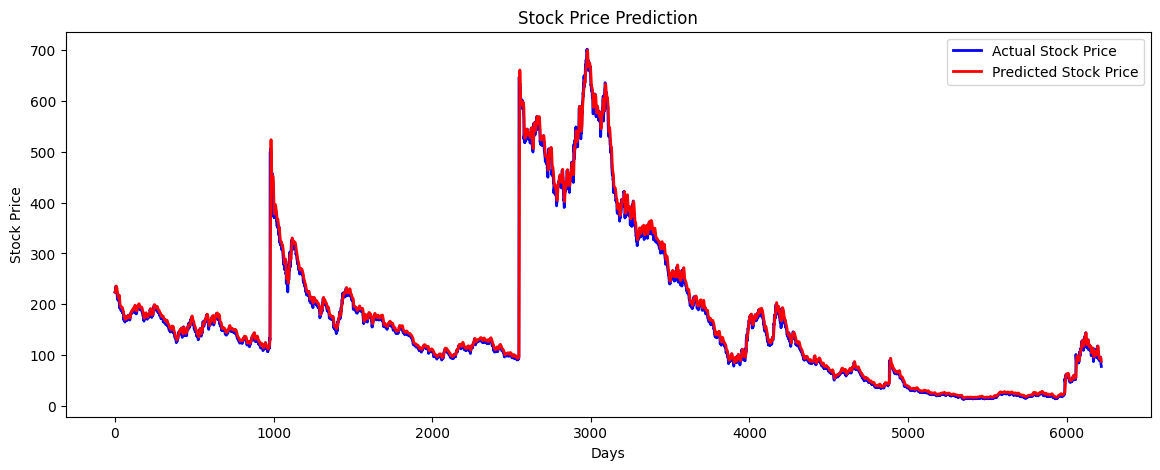

In [ ]:
import matplotlib.pyplot as plt

# Plotting the actual prices vs predicted prices
plt.figure(figsize=(14, 5))
plt.plot(actual_prices, color='blue', label='Actual Stock Price', linewidth=2)
plt.plot(train_predictions, color='red', label='Predicted Stock Price', linewidth=2)
plt.title('Stock Price Prediction')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


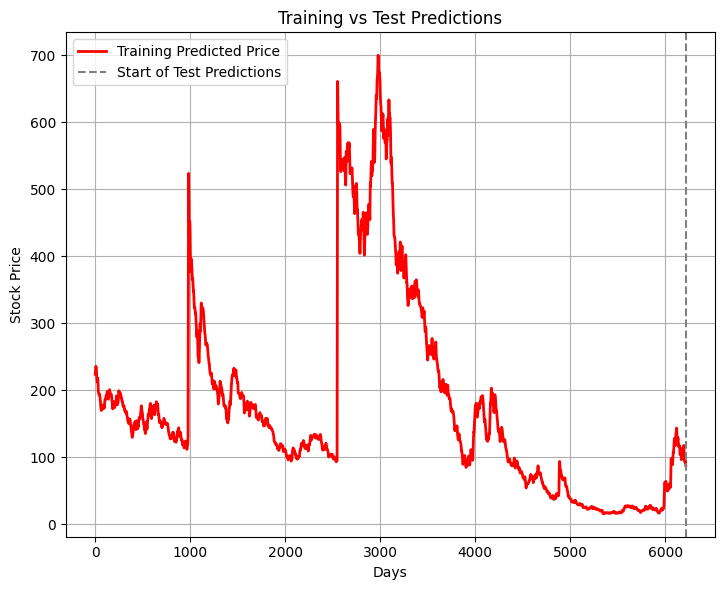

In [ ]:
import matplotlib.pyplot as plt

# Assuming `train_predictions`, `actual_prices`, and `test_predictions` are defined

plt.figure(figsize=(14, 6))



# Subplot for Training vs Test Predictions
plt.subplot(1, 2, 2)
plt.plot(train_predictions, color='red', label='Training Predicted Price', linewidth=2)
if 'test_predictions' in locals():
    plt.plot(range(len(train_predictions), len(train_predictions) + len(test_predictions)),
             test_predictions, color='green', label='Test Predicted Price', linewidth=2)
plt.title('Training vs Test Predictions')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.axvline(x=len(train_predictions), color='gray', linestyle='--', label='Start of Test Predictions')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


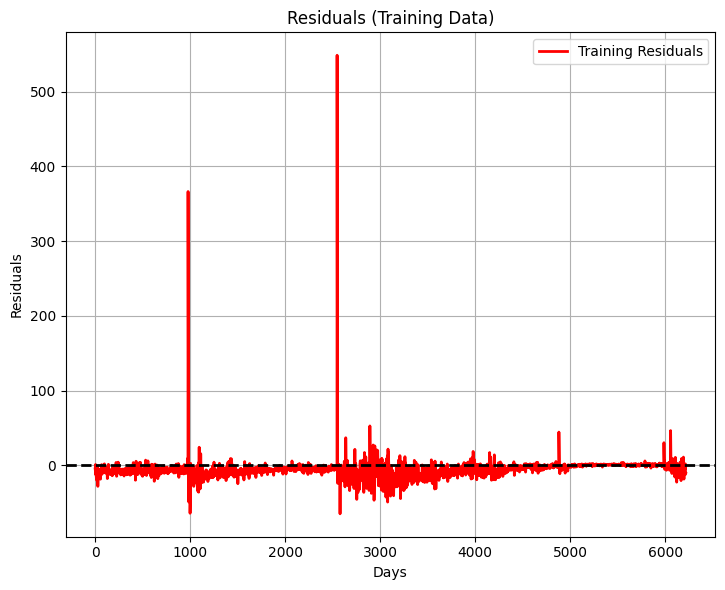

In [ ]:
# Calculate residuals
residuals_train = actual_prices - train_predictions
if 'test_predictions' in locals():
    residuals_test = actual_prices[-len(test_predictions):] - test_predictions

# Plotting the residuals
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(residuals_train, color='red', label='Training Residuals', linewidth=2)
plt.axhline(0, color='black', linestyle='--', linewidth=2)
plt.title('Residuals (Training Data)')
plt.xlabel('Days')
plt.ylabel('Residuals')
plt.legend()
plt.grid()

if 'test_predictions' in locals():
    plt.subplot(1, 2, 2)
    plt.plot(residuals_test, color='green', label='Test Residuals', linewidth=2)
    plt.axhline(0, color='black', linestyle='--', linewidth=2)
    plt.title('Residuals (Test Data)')
    plt.xlabel('Days')
    plt.ylabel('Residuals')
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()


Epoch 1/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - loss: 0.0011 - val_loss: 4.8949e-05
Epoch 2/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - loss: 8.8266e-04 - val_loss: 7.3258e-05
Epoch 3/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - loss: 6.9784e-04 - val_loss: 3.4423e-05
Epoch 4/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - loss: 8.0544e-04 - val_loss: 4.9273e-05
Epoch 5/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - loss: 0.0011 - val_loss: 3.9885e-05
Epoch 6/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - loss: 7.0101e-04 - val_loss: 1.3287e-04
Epoch 7/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 18s 53ms/step - loss: 9.3092e-04 - val_loss: 4.7138e-05
Epoch 8/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step - loss: 5.4409e-04 - val_loss: 1.7792e-05
Epoch 9/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - loss: 6.0585e-04 - val_loss: 4.6576e-05
Epoch 10/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - loss: 5.1699e-04 - val_loss: 1.8410e-05


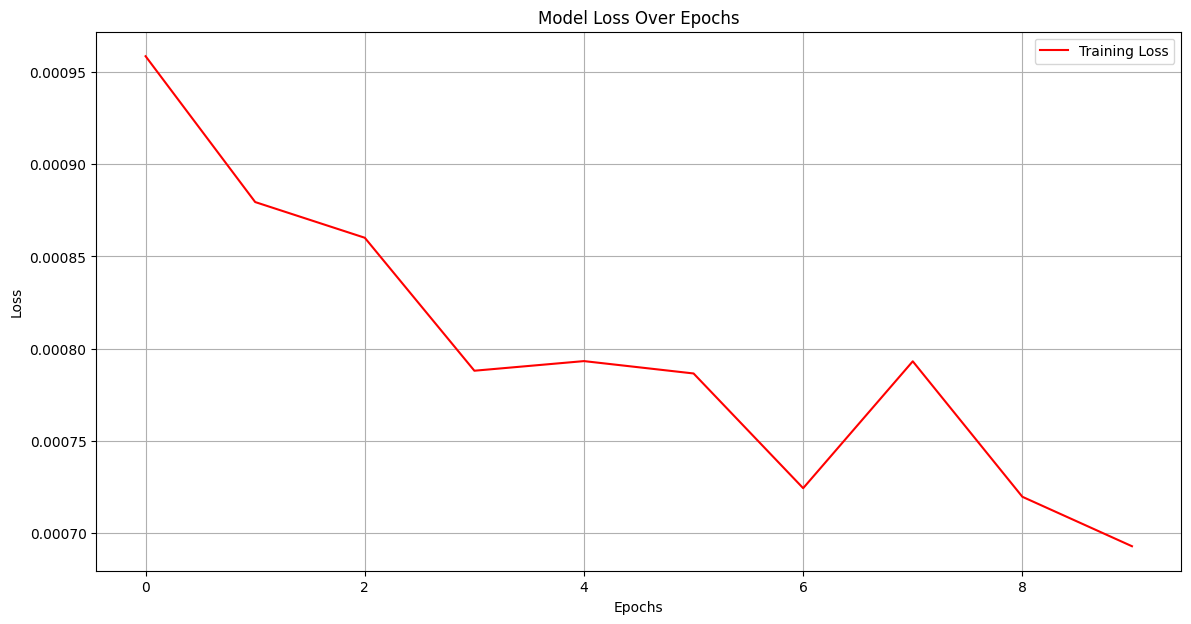

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import requests

# Your existing model code here...

def plot_loss(history):
    plt.figure(figsize=(14, 7))
    plt.plot(history.history['loss'], label='Training Loss', color='red')
    plt.title('Model Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

# Sample model training code
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Call the plot_loss function
plot_loss(history)


Fetching data from Alpha Vantage...


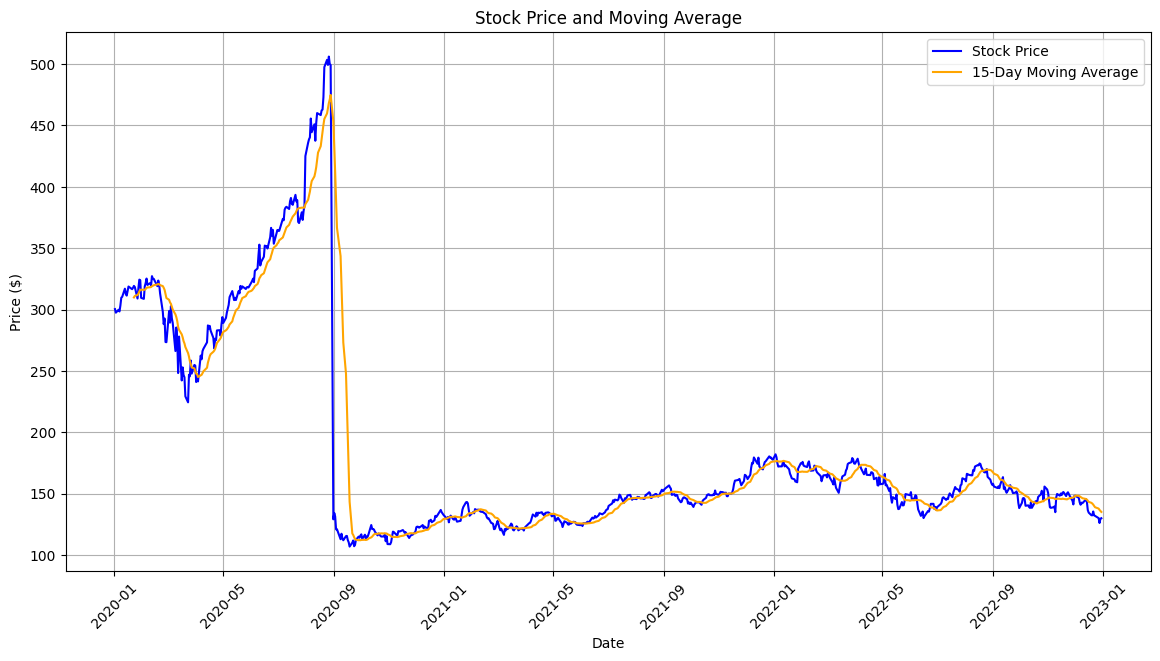

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from alpha_vantage.timeseries import TimeSeries

# Replace 'YOUR_API_KEY' with your actual Alpha Vantage API key
api_key = 'EHHIB7PXEQ6A4889'

# Fetch the stock data
def get_stock_data(ticker, start_date, end_date):
    # Construct cache file path
    cache_file = f'{ticker}_{start_date}_{end_date}.csv'

    # Check if data exists in cache
    if os.path.exists(cache_file):
        print("Loading data from cache...")  # Indicate data loaded from cache
        data = pd.read_csv(cache_file, index_col=0, parse_dates=True)
    else:
        print("Fetching data from Alpha Vantage...")  # Indicate data fetched from API
        ts = TimeSeries(key=api_key, output_format='pandas')
        data, meta_data = ts.get_daily(symbol=ticker, outputsize='full')
        data = data.sort_index()  # Sort the index chronologically
        data = data.loc[start_date:end_date]  # Filter the date range
        data = data[['4. close']]  # Get the 'close' price
        data.columns = ['Close']  # Rename to 'Close'
        data.to_csv(cache_file)  # Save to cache

    return data

# Plot moving average
def plot_moving_average(stock_data, window_size=5):
    """
    Plots stock price and moving average.

    Args:
        stock_data (pd.DataFrame): Stock data with date as index and 'Close' price column.
        window_size (int): Window size for calculating moving average.
    """

    # Check if 'Close' column exists
    if 'Close' not in stock_data.columns:
        raise ValueError("Data must contain 'Close' column for stock prices")

    # Extract 'Close' prices
    prices = stock_data['Close']

    # Calculate the moving average
    moving_avg = prices.rolling(window=window_size).mean()

    # Plotting the stock prices and moving average
    plt.figure(figsize=(14, 7))
    plt.plot(prices.index, prices, label='Stock Price', color='blue')
    plt.plot(moving_avg.index, moving_avg, label=f'{window_size}-Day Moving Average', color='orange')
    plt.title('Stock Price and Moving Average')
    plt.xlabel('Date')
    plt.ylabel('Price ($)')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
ticker = 'AAPL'
start_date = '2020-01-01'
end_date = '2023-01-01'

# Fetch data and plot
data = get_stock_data(ticker, start_date, end_date)
plot_moving_average(data, window_size=15)


In [ ]:
!pip install requests

Full response from API: {'Meta Data': {'1. Information': 'Daily Prices (open, high, low, close) and Volumes', '2. Symbol': 'AAPL', '3. Last Refreshed': '2024-10-15', '4. Output Size': 'Full size', '5. Time Zone': 'US/Eastern'}, 'Time Series (Daily)': {'2024-10-15': {'1. open': '233.6100', '2. high': '237.4900', '3. low': '232.3700', '4. close': '233.8500', '5. volume': '64751367'}, '2024-10-14': {'1. open': '228.7000', '2. high': '231.7300', '3. low': '228.6000', '4. close': '231.3000', '5. volume': '39882085'}, '2024-10-11': {'1. open': '229.3000', '2. high': '229.4100', '3. low': '227.3400', '4. close': '227.5500', '5. volume': '31759188'}, '2024-10-10': {'1. open': '227.7800', '2. high': '229.5000', '3. low': '227.1700', '4. close': '229.0400', '5. volume': '28183544'}, '2024-10-09': {'1. open': '225.2300', '2. high': '229.7500', '3. low': '224.8300', '4. close': '229.5400', '5. volume': '33591091'}, '2024-10-08': {'1. open': '224.3000', '2. high': '225.9800', '3. low': '223.2500', 

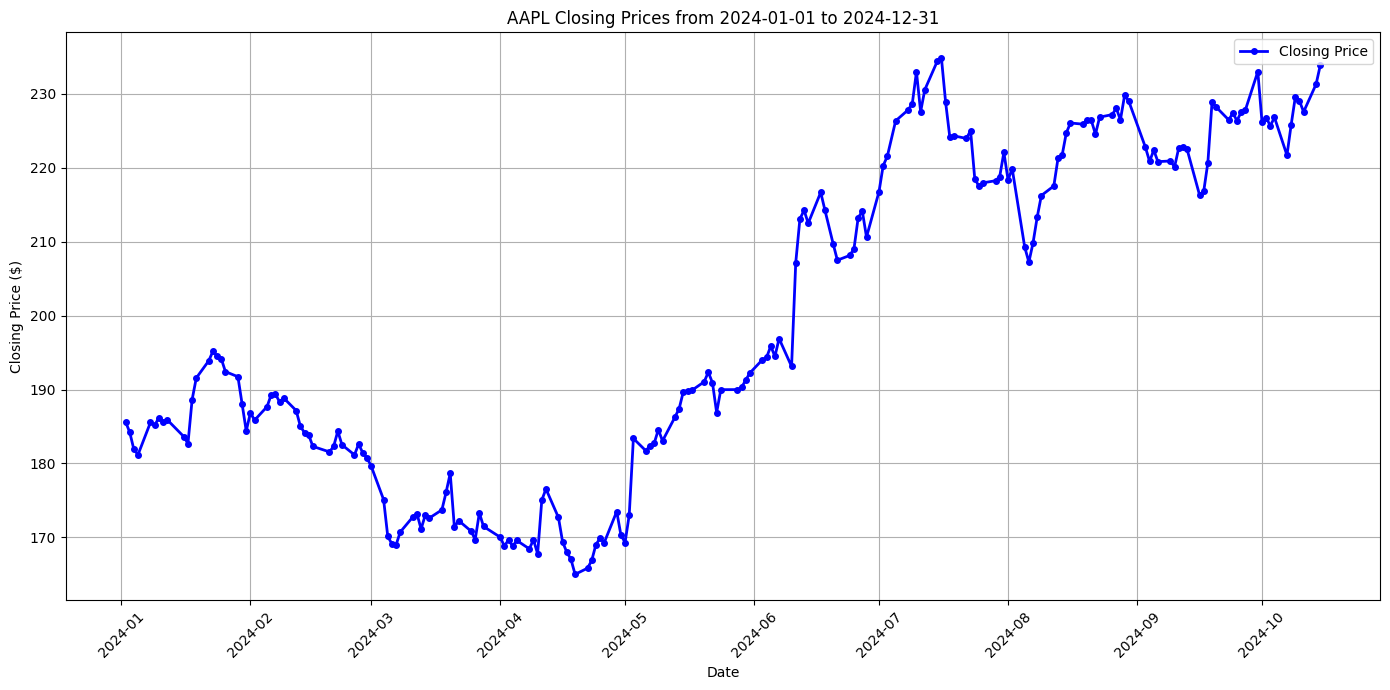

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

def get_actual_future_prices(stock_symbol, start_date, end_date, api_key):
    """Fetches actual future prices from Alpha Vantage using a free endpoint."""
    url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={stock_symbol}&outputsize=full&apikey={api_key}'

    try:
        response = requests.get(url)
        response.raise_for_status()  # Raise an error for bad responses
        data = response.json()

        # Print the full response for debugging
        print("Full response from API:", data)

        # Check if the expected data is present
        if 'Time Series (Daily)' not in data:
            if 'Note' in data:  # Check if there's a note regarding usage limits
                print("Note:", data['Note'])
            raise ValueError("Error fetching data: Time Series (Daily) not found in response.")

        prices = {}

        # Loop through the time series data
        for date, metrics in data['Time Series (Daily)'].items():
            if start_date <= date <= end_date:
                # Store the closing price for the specified date range
                prices[date] = float(metrics['4. close'])  # '4. close' gives the closing price

        return prices

    except requests.exceptions.RequestException as e:
        print(f"Error fetching data: {e}")
        return {}
    except ValueError as ve:
        print(ve)
        return {}

# Example usage
api_key = 'EHHIB7PXEQ6A4889'  # Your Alpha Vantage API key
stock_symbol = 'AAPL'  # Example stock symbol
start_date = '2024-01-01'
end_date = '2024-12-31'

# Fetch actual prices
actual_prices = get_actual_future_prices(stock_symbol, start_date, end_date, api_key)

# Convert the prices dictionary to a DataFrame
if actual_prices:
    prices_df = pd.DataFrame(list(actual_prices.items()), columns=['Date', 'Closing Price'])
    prices_df['Date'] = pd.to_datetime(prices_df['Date'])  # Convert date strings to datetime objects
    prices_df.set_index('Date', inplace=True)  # Set the date as the index

    # Print the DataFrame
    print(prices_df)

    # Plotting as a line graph
    plt.figure(figsize=(14, 7))
    plt.plot(prices_df.index, prices_df['Closing Price'], color='blue', linewidth=2, marker='o', markersize=4, label='Closing Price')
    plt.title(f'{stock_symbol} Closing Prices from {start_date} to {end_date}')
    plt.xlabel('Date')
    plt.ylabel('Closing Price ($)')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels
    plt.show()
else:
    print("No data to display.")
